## IR Pedestrian Classification Using CNN and Deep ResNet with PyTorch

Outline of the project:

* [Introduction](#1)
* [Packages & Libraries](#3)
* [Data Import and Preparation](#4)
* [CNN Model](#5)
* [Deep Residual Networks (ResNet)](#6)

<a id = "1"></a>
### Introduction

<img src="https://www.researchgate.net/publication/287805480/figure/fig3/AS:668583856201745@1536414221921/Examples-from-the-Classification-Dataset-a-examples-of-pedestrians-and-b-examples.png">

The database consists of FIR images collected from a vehicle driven in outdoors urban scenarios. Images were acquired with an Indigo Omega imager, with a resolution of 164x129 pixels, a grey-level scale of 14 bits, and focal length of 318 pixels. The camera was mounted on the exterior of the vehicle, to avoid infrared filtering of the windshield. Recorded images were manually annotated, where each pedestrian is labelled as a bounding box. To prevent bias introduced by border artifacts their height is subsequently upscaled by 5%. The pedestrians appear in an up-right position.
 
The dataset is divided in two: (i) Classification dataset: positives and randomly sampled negatives with a fixed height-width ratio of (1/2) and rescaled to 64x32 pixels, and (ii) Detection Dataset: Original positive and negative images with annotations.

<a id = "2"></a>
### Packages & Libraries

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch.optim as optim
from torch.autograd import Variable

In [13]:
# for using GPU on local after installation of cuda

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<a id = "3"></a>
### Data Import and Preparation

In [14]:
def read_images(path, num_img):
    array = np.zeros([num_img, 64*32])
    i = 0
    for img in os.listdir(path):
        img_path = path + "/" + img
        img = Image.open(img_path, mode = "r")
        data = np.asarray(img, dtype = "uint8")
        data = data.flatten()
        array[i, :] = data
        i += 1
    return array

In [22]:
# define a function that returns x and y tensors
def prepare_tensors(path, num_img, label = "negative"):

    array = read_images(path, num_img)
    x_tensor = torch.from_numpy(array)
    if label == "negative":
        y_tensor = torch.zeros(num_img, dtype = torch.long)
    elif label == "positive":
        y_tensor = torch.ones(num_img, dtype = torch.long)
    else:
        return "Error"
    
    return x_tensor, y_tensor

In [15]:
# create paths
train_path="../input/lsi-far-infrared-pedestrian-dataset/LSIFIR/Classification/Train"
test_path="../input/lsi-far-infrared-pedestrian-dataset/LSIFIR/Classification/Test"

train_negative_path=train_path + "/neg"
numOf_train_negative_img=43390
train_positive_path=train_path + "/pos"
numOf_train_positive_img=10208

test_negative_path=test_path + "/neg"
numOf_test_negative_img=22050
test_positive_path=test_path + "/pos"
numOf_test_positive_img=5944

In [24]:
# train negative images
x_train_neg_tensor, y_train_neg_tensor = prepare_tensors(train_negative_path, numOf_train_negative_img)
print("Size of X Train Negative Tensor: ", x_train_neg_tensor.size())
print("Size of Y Train Negative Tensor: ", y_train_neg_tensor.size())

Size of X Train Negative Tensor:  torch.Size([43390, 2048])
Size of Y Train Negative Tensor:  torch.Size([43390])


In [25]:
# train positive images
x_train_pos_tensor, y_train_pos_tensor = prepare_tensors(train_positive_path, numOf_train_positive_img, label = "positive")
print("Size of X Train Positive Tensor: ", x_train_pos_tensor.size())
print("Size of Y Train Positive Tensor: ", y_train_pos_tensor.size())

Size of X Train Positive Tensor:  torch.Size([10208, 2048])
Size of Y Train Positive Tensor:  torch.Size([10208])


In [218]:
# test negative images
x_test_neg_tensor, y_test_neg_tensor = prepare_tensors(test_negative_path, numOf_test_negative_img)
print("Size of X Test Negative Tensor: ", x_test_neg_tensor.size())
print("Size of Y Test Negative Tensor: ", y_test_neg_tensor.size())

Size of X Test Negative Tensor:  torch.Size([22050, 2048])
Size of Y Test Negative Tensor:  torch.Size([22050])


In [219]:
x_test_neg_tensor = x_test_neg_tensor[:20855,:]
y_test_neg_tensor = y_test_neg_tensor[:20855,]

In [220]:
print("Size of X Test Negative Tensor: ", x_test_neg_tensor.size())
print("Size of Y Test Negative Tensor: ", y_test_neg_tensor.size())

Size of X Test Negative Tensor:  torch.Size([20855, 2048])
Size of Y Test Negative Tensor:  torch.Size([20855])


In [27]:
# test positive images
x_test_pos_tensor, y_test_pos_tensor = prepare_tensors(test_positive_path, numOf_test_positive_img)
print("Size of X Test Positive Tensor: ", x_test_pos_tensor.size())
print("Size of Y Test Positive Tensor: ", y_test_pos_tensor.size())

Size of X Test Positive Tensor:  torch.Size([5944, 2048])
Size of Y Test Positive Tensor:  torch.Size([5944])


In [28]:
# concat train data
x_train = torch.cat((x_train_neg_tensor,x_train_pos_tensor),0)
y_train = torch.cat((y_train_neg_tensor,y_train_pos_tensor),0)
print("Size of X Train: ",x_train.size())
print("Size of Y Train: ",y_train.size())

Size of X Train:  torch.Size([53598, 2048])
Size of Y Train:  torch.Size([53598])


In [233]:
# concat test data
x_test = torch.cat((x_test_neg_tensor,x_test_pos_tensor),0)
y_test = torch.cat((y_test_neg_tensor,y_test_pos_tensor),0)
print("Size of X Train: ",x_test.size())
print("Size of Y Train: ",y_test.size())

Size of X Train:  torch.Size([26799, 2048])
Size of Y Train:  torch.Size([26799])


Label of the image:  1


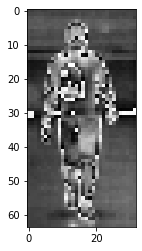

In [49]:
# visualize a random positive image
print("Label of the image: ", y_train[48000].item())
plt.imshow(x_train[48000, :].reshape(64,32), cmap = "gray")

Label of the image:  0


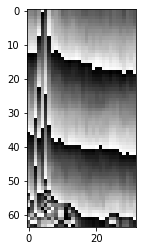

In [48]:
# visualize a random negative image
print("Label of the image: ", y_train[5].item())
plt.imshow(x_train[5, :].reshape(64,32), cmap = "gray")

<a id = "4"></a>
### CNN Model

In [241]:
# hyperparameters
num_epochs = 5
num_classes = 2
batch_size = 8933 # total training data 53598 / 6 = 8933
learning_rate = 0.0001

In [242]:
# create CNNModel class
class CNNModel(nn.Module):
    
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1= nn.Conv2d(1,10,5)    # 1-input channel, 10-output channel, 3- kernel size 3x3
        self.pool= nn.MaxPool2d(2,2)     # max pooling (2x2)
        self.conv2= nn.Conv2d(10,16,5)   # 10-input channel, 16-output channel, 3- kernel size 3x3
        
        self.fc1=nn.Linear(16*13*5,520)   # fully connected layers (input, output)
        self.fc2=nn.Linear(520,130)          
        self.fc3=nn.Linear(130,num_classes)
        
    def forward(self, x):
        # Convolution 1 and max pooling
        out = self.conv1(x)
        out = F.relu(out)
        out = self.pool(out)
        
        # Convolution 2 and max pooling
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool(out)
        
        # flatten
        out = torch.flatten(out, 1)
        
        # Linear function (readout)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out

In [243]:
# prepare data for modelling
train = torch.utils.data.TensorDataset(x_train, y_train)
trainLoader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

test = torch.utils.data.TensorDataset(x_test, y_test)
testLoader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [244]:
# instantiate model
model = CNNModel()

In [245]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.8)

In [247]:
# training model
start = time.time()

count = 0
loss_list = []
iteration_list = []
accuracy_list = []

use_gpu = False

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainLoader, 0):
        
        train = Variable(images.view(batch_size, 1, 64, 32).float())
        labels = Variable(labels)
        
        # clear gradients
        optimizer.zero_grad()
        
        # forward propagation
        outputs = model(train)
        
        # calculate softmax and cross entropy loss
        loss = criterion(outputs, labels)
        
        # calculating gradients
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        count += 1
        
        if count % 5 == 0:
            # calculate accuracy
            correct = 0
            total = 0
            # iterate through test dataset
            with torch.no_grad(): # close back prop
                
                for images, labels in testLoader:

                    test = Variable(images.view(batch_size, 1, 64, 32).float())

                    # forward propagation
                    outputs = model(test)

                    # get prediction from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # total number of labels
                    total += len(labels)

                    correct += (predicted == labels).sum().item()
                
                accuracy = 100 * correct / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
            
        if count % 10 == 0:
            # print loss
            print("Iteration: {} Loss: {} Accuracy: {}".format(count, loss.data, accuracy))


stop = time.time()
time_difference = (stop - start) / 60
print("Process time: ", time_difference)

Iteration: 10 Loss: 0.36135926842689514 Accuracy: 93.77588715996866
Iteration: 20 Loss: 0.3333502411842346 Accuracy: 92.98481286615173
Iteration: 30 Loss: 0.3053607642650604 Accuracy: 92.24971081010486
Process time:  4.724655810991923


In [248]:
# save model
path = './pedestrian.pth'
torch.save(model.state_dict(), path)

To be continued!